# ERA5 数据简介

ERA5 是 ECMWF（欧洲中期天气预报中心）提供的第五代再分析数据（ECMWF Reanalysis），广泛用于气象、气候和环境科学研究。ERA5 提供高空间分辨率、高时间分辨率的全球气象变量数据，可用于天气分析、气候监测和数值模拟模型验证。

下载链接：https://cds.climate.copernicus.eu/

---

## 1. ERA5 数据特点

- **时间范围**：1950年至今（逐年更新）  
- **时间分辨率**：小时级（Hourly）  
- **空间分辨率**：约 0.25° × 0.25°（约 31 km 网格）  
- **格式**：NetCDF、GRIB  
- **变量类型**：
  - **Single Level（地面/表层变量）**  
  - **Pressure Levels（高空气压面变量）**

---

## 2. Single Level（地面/表层变量）

### 2.1 特点

- 数据仅在地面或表层高度上提供，不涉及垂直层次。
- 常用变量：
  - 2 米温度（`2m_temperature`）  
  - 2 米相对湿度（`2m_relative_humidity`）  
  - 地面风速（`10m_u_component_of_wind`、`10m_v_component_of_wind`）  
  - 降水量（`total_precipitation`）  
  - 地表压力（`surface_pressure`）  
  - 日照/辐射（`surface_net_solar_radiation`）  

### 2.2 数据形状

- 一般为 `[time, lat, lon]` 的三维数组  
- 示例：
```python
T2m: shape = [8760, 721, 1440]  # 一年小时数据，lat=721, lon=1440
```
### 2.3 使用示例（Python + xarray）
```python
import xarray as xr
ds = xr.open_dataset("era5_single_level.nc")
t2m = ds["t2m"]  # 2米温度
print(t2m.shape)  # 输出: (time, lat, lon)
```
### 3. Pressure Levels（高空气压面变量）

#### 3.1 特点

- 数据沿垂直方向提供，按标准气压面（Pa 或 hPa）存储。
- 常用变量：
  - 温度（`temperature`）  
  - 相对湿度（`relative_humidity`）  
  - 风速分量（`u`, `v`）  
  - 位势高度（`geopotential`）  
- 常见气压面：

#### 3.2 数据形状

- Pressure Levels 数据一般为 `[time, level, lat, lon]` 的四维数组  
- 示例：
```python
temperature: shape = [8760, 37, 721, 1440]  # 37 个标准气压面
```

### singel level 的处理及可视化示例
从低分辨率数据数据插值到指定分辨率

In [1]:
# 导入库函数
import os
import numpy as np
import xarray as xr
import xesmf as xe
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# 读取era5数据
era_file = '/data/xmr/xmrcode/data_process/data/era5/single_level/20180312_singlelevels.nc'

era_ds = xr.open_dataset(era_file)
era_ds = era_ds.rename({'latitude': 'lat', 'longitude': 'lon'})  # 确保坐标统一

In [3]:
# 打印变量及形状
var_names = list(era_ds.data_vars)
print("ERA5 文件中的变量：")
for i, v in enumerate(var_names):
    print(f"{i+1}. {v},形状为：{era_ds[v].shape}")

ERA5 文件中的变量：
1. u10,形状为：(9, 57, 53)
2. v10,形状为：(9, 57, 53)
3. d2m,形状为：(9, 57, 53)
4. t2m,形状为：(9, 57, 53)
5. sst,形状为：(9, 57, 53)
6. sp,形状为：(9, 57, 53)
7. u100,形状为：(9, 57, 53)
8. v100,形状为：(9, 57, 53)
9. hcc,形状为：(9, 57, 53)
10. lcc,形状为：(9, 57, 53)
11. mcc,形状为：(9, 57, 53)
12. tcc,形状为：(9, 57, 53)


In [4]:
lat_min, lat_max = 28.7, 41.5
# 差12.8
lon_min, lon_max = 116.2, 129.0
nx, ny = 1024, 1024  # 可调节分辨率
12.8/1024=0.0125

lats_1d = np.linspace(lat_max, lat_min, ny)
lons_1d = np.linspace(lon_min, lon_max, nx)

era_grid = {'lat': era_ds.lat, 'lon': era_ds.lon}
sat_grid = {'lat': lats_1d, 'lon': lons_1d}

regridder = xe.Regridder(era_grid, sat_grid, method='bilinear', periodic=False, reuse_weights=True)

Reuse existing file: bilinear_57x53_256x256.nc


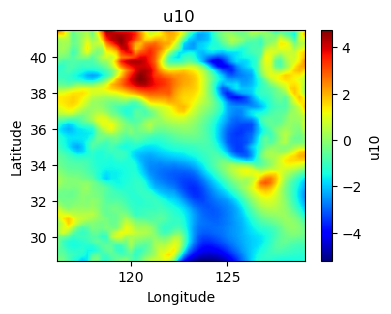

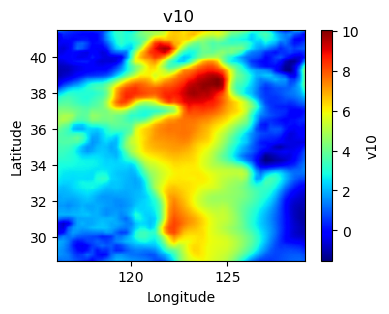

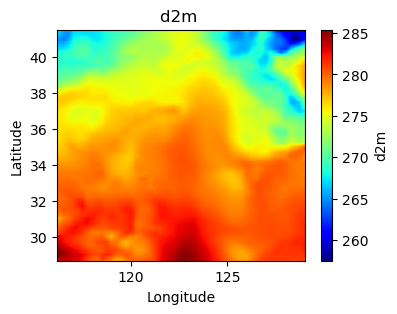

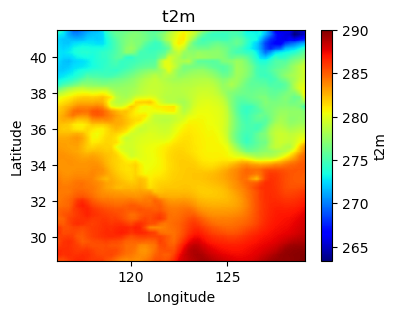

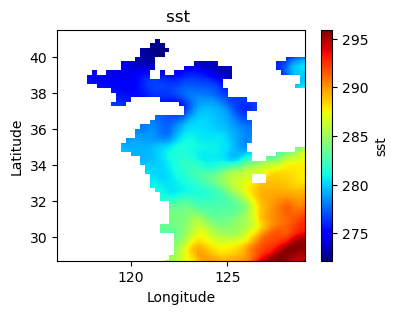

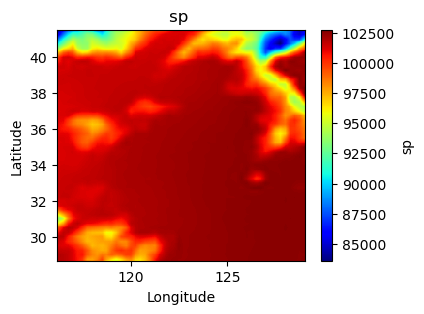

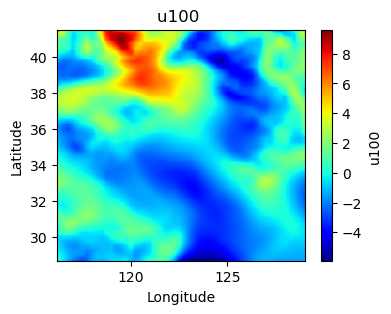

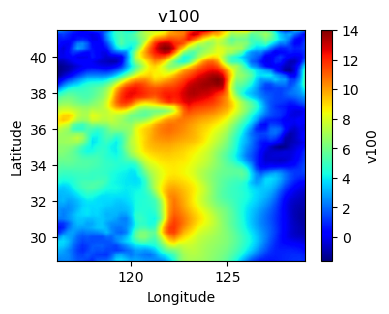

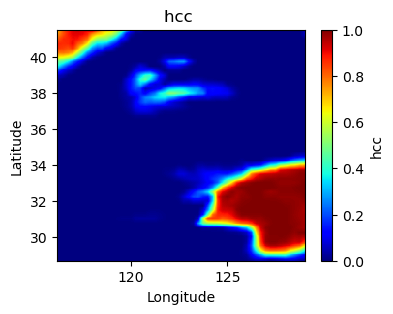

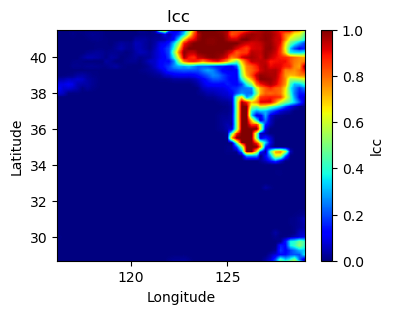

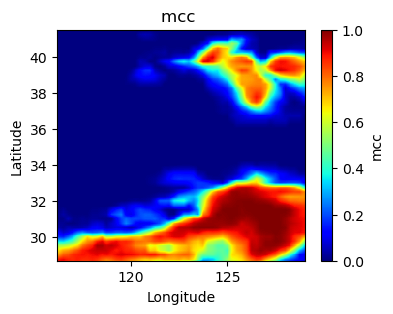

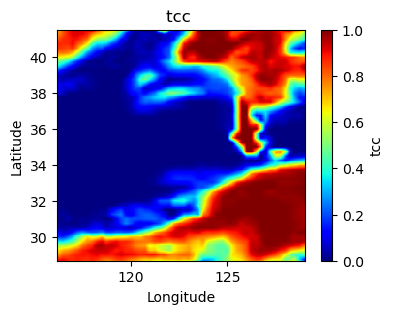

In [8]:
for var_name in var_names:
    var_data = era_ds[var_name]

    # 取第一个时间片
    if 'time' in var_data.dims:
        data_slice = var_data.isel(time=0)
    elif 'valid_time' in var_data.dims:
        data_slice = var_data.isel(valid_time=0)
    else:
        data_slice = var_data

    # 如果变量有 (lat, lon)，则绘图
    if ('lat' in data_slice.dims) and ('lon' in data_slice.dims):
        interp_data = regridder(data_slice)

        plt.figure(figsize=(4, 3))
        plt.pcolormesh(interp_data['lon'], interp_data['lat'], interp_data, cmap='jet')
        plt.colorbar(label=var_name)
        plt.title(f"{var_name} ")
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()
    else:
        print(f"变量 {var_name} 无 (lat, lon) 维度，跳过可视化。")

### pressure levels 的处理及可视化示例
从低分辨率数据数据插值到指定分辨率

In [9]:
# 读取数据并查看变量
era_file = '/data/xmr/xmrcode/ERA5+satlite/data/era5/pressure_levels/20180313.nc'

era_ds = xr.open_dataset(era_file)
era_ds = era_ds.rename({'latitude': 'lat', 'longitude': 'lon'})  # 确保坐标统一
var_names = list(era_ds.data_vars)
print("ERA5 文件中的变量：")
for i, v in enumerate(var_names):
    print(f"{i+1}. {v},形状为：{era_ds[v].shape}")

ERA5 文件中的变量：
1. number,形状为：()
2. expver,形状为：(9,)
3. d,形状为：(9, 6, 57, 53)
4. cc,形状为：(9, 6, 57, 53)
5. z,形状为：(9, 6, 57, 53)
6. o3,形状为：(9, 6, 57, 53)
7. pv,形状为：(9, 6, 57, 53)
8. r,形状为：(9, 6, 57, 53)
9. ciwc,形状为：(9, 6, 57, 53)
10. clwc,形状为：(9, 6, 57, 53)
11. q,形状为：(9, 6, 57, 53)
12. crwc,形状为：(9, 6, 57, 53)
13. cswc,形状为：(9, 6, 57, 53)
14. t,形状为：(9, 6, 57, 53)
15. u,形状为：(9, 6, 57, 53)
16. v,形状为：(9, 6, 57, 53)
17. w,形状为：(9, 6, 57, 53)
18. vo,形状为：(9, 6, 57, 53)


In [10]:
# 创建卫星网格并插值
lat_min, lat_max = 28.7, 41.5
lon_min, lon_max = 116.2, 129.0
nx, ny = 256, 256

lats_1d = np.linspace(lat_max, lat_min, ny)
lons_1d = np.linspace(lon_min, lon_max, nx)

era_grid = {'lat': era_ds.lat, 'lon': era_ds.lon}
sat_grid = {'lat': lats_1d, 'lon': lons_1d}

regridder = xe.Regridder(era_grid, sat_grid, method='bilinear', periodic=False, reuse_weights=True)

Reuse existing file: bilinear_57x53_256x256.nc


正在处理 d, dims=('valid_time', 'pressure_level', 'lat', 'lon')


/opt/anaconda3/envs/seafog_h8_2/lib/python3.8/site-packages/xesmf/frontend.py:412: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/opt/anaconda3/envs/seafog_h8_2/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/seafog_h8_2/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/seafog_h8_2/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/seafog_h8_2/lib/python3.8/site-packages/IPython/core/pylabtools.

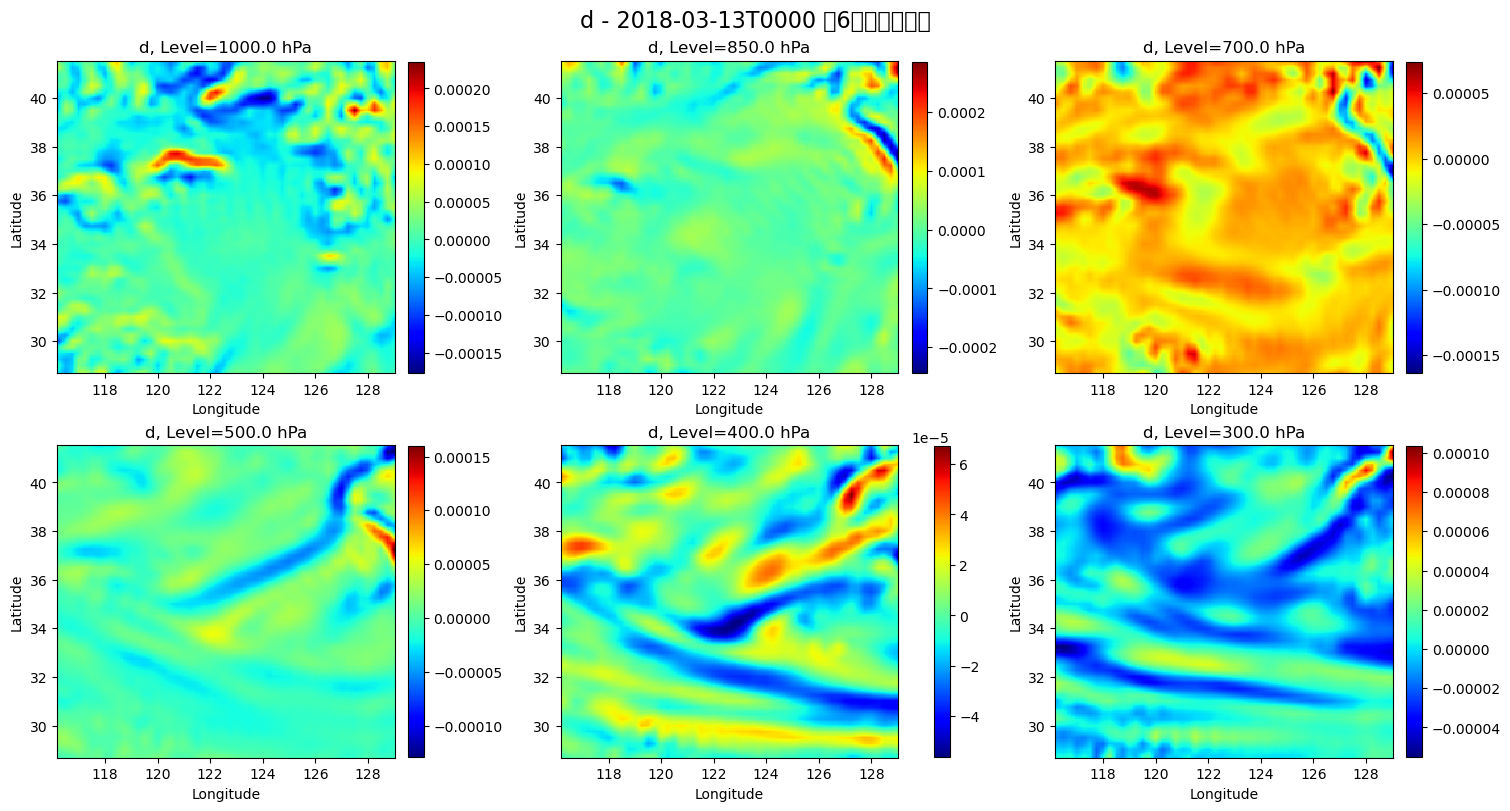

d 保存完成，共 9 个时间切片
正在处理 cc, dims=('valid_time', 'pressure_level', 'lat', 'lon')


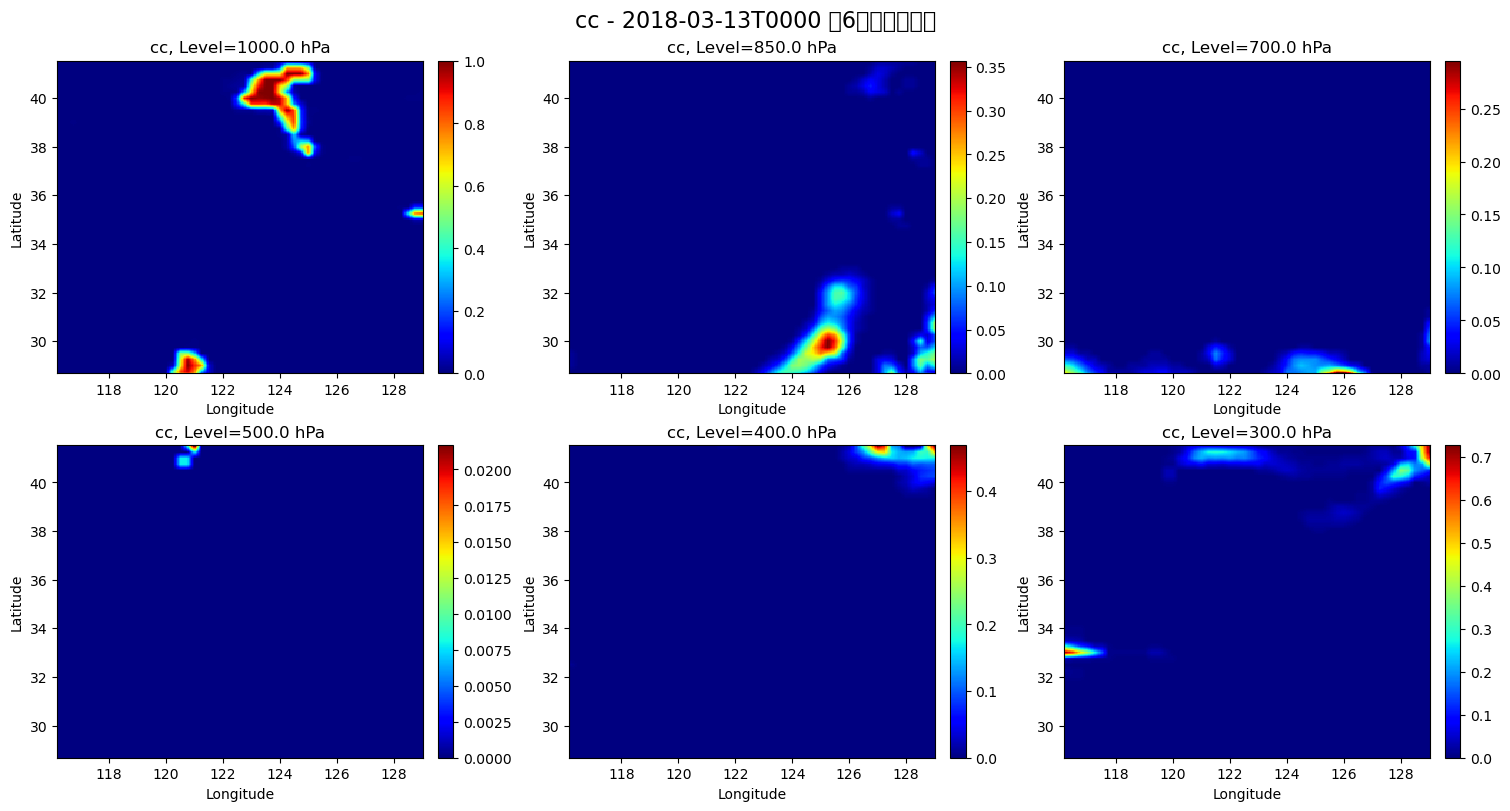

cc 保存完成，共 9 个时间切片
正在处理 z, dims=('valid_time', 'pressure_level', 'lat', 'lon')


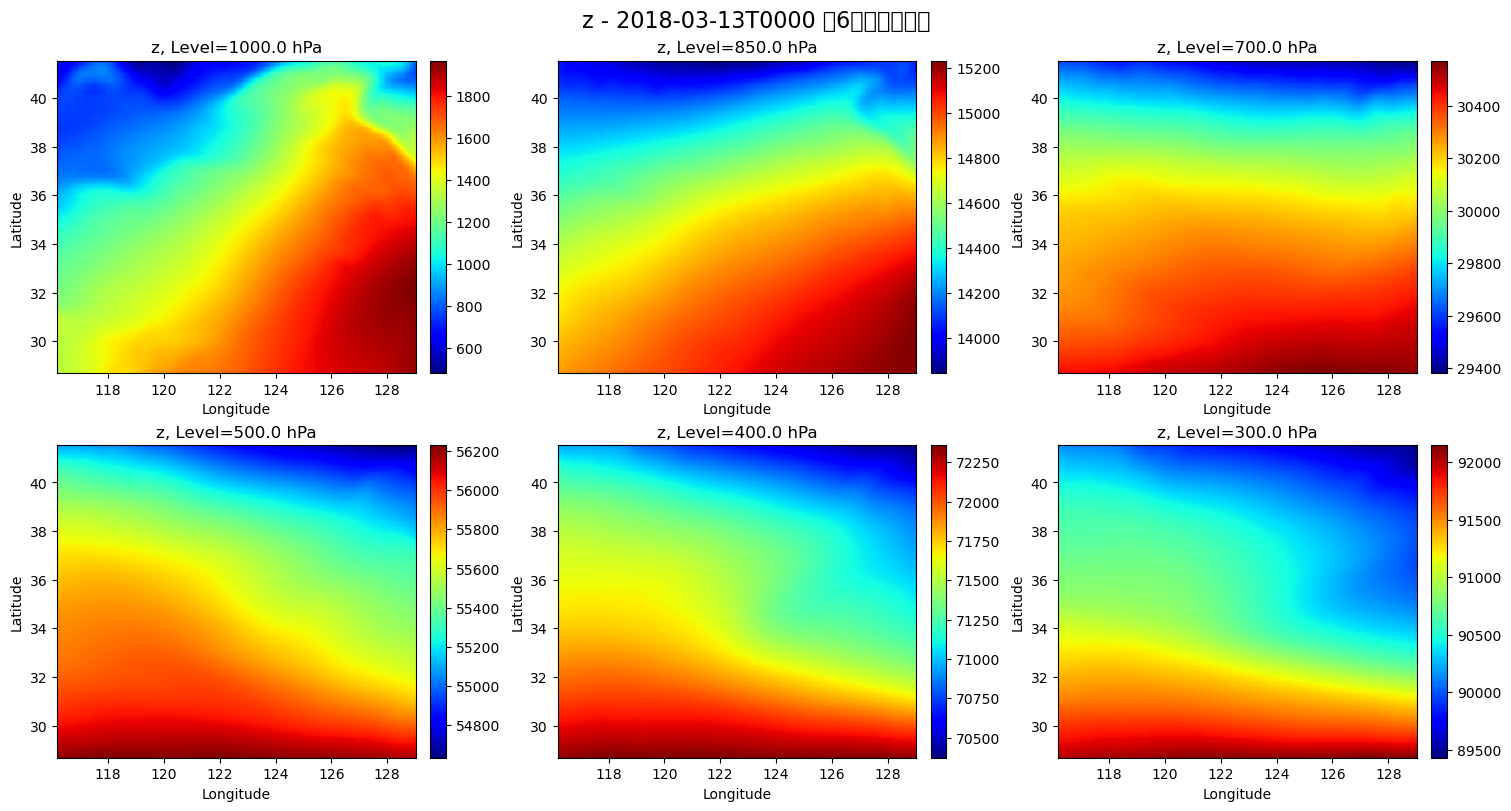

z 保存完成，共 9 个时间切片
正在处理 o3, dims=('valid_time', 'pressure_level', 'lat', 'lon')


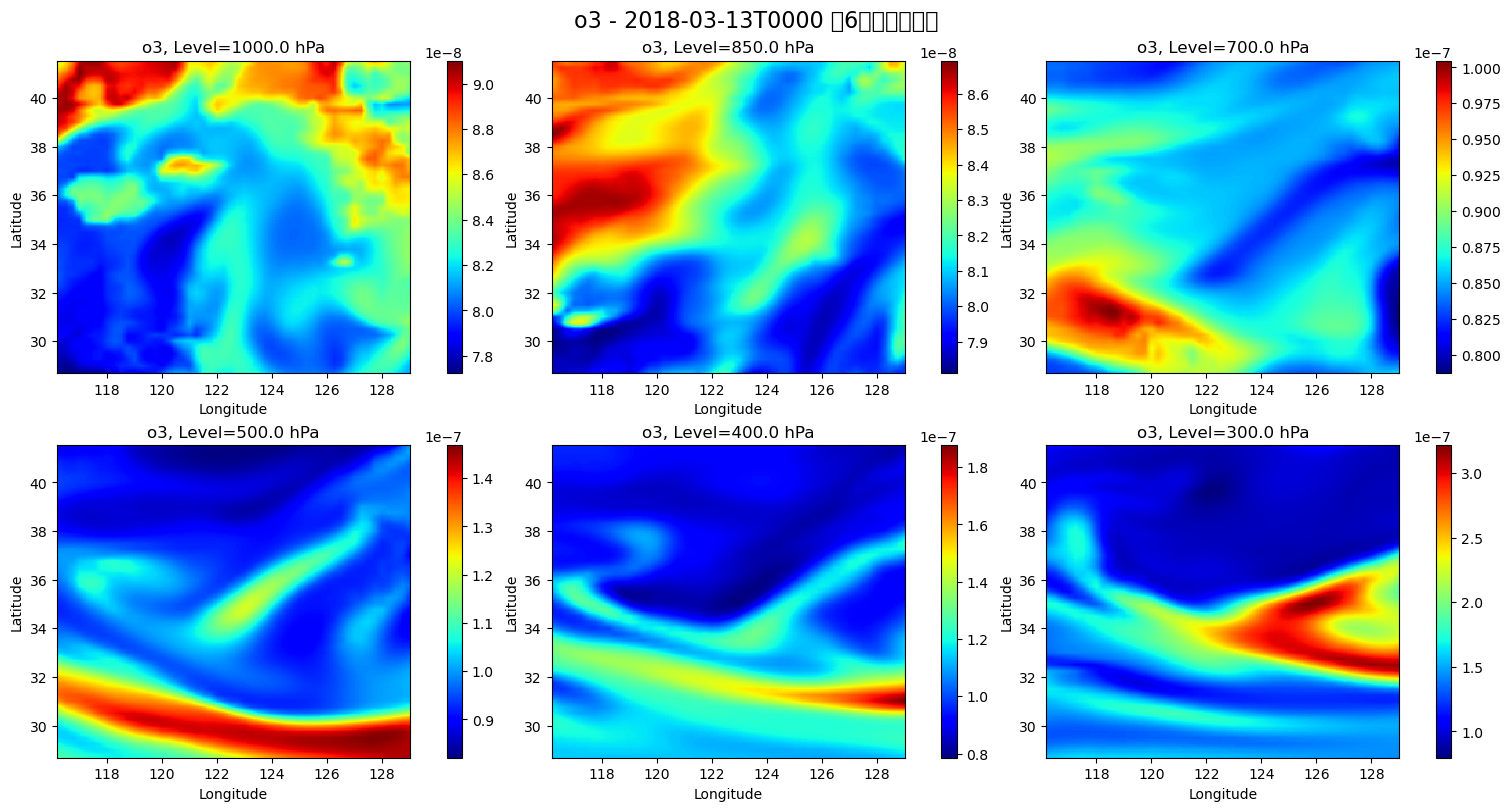

o3 保存完成，共 9 个时间切片
正在处理 pv, dims=('valid_time', 'pressure_level', 'lat', 'lon')


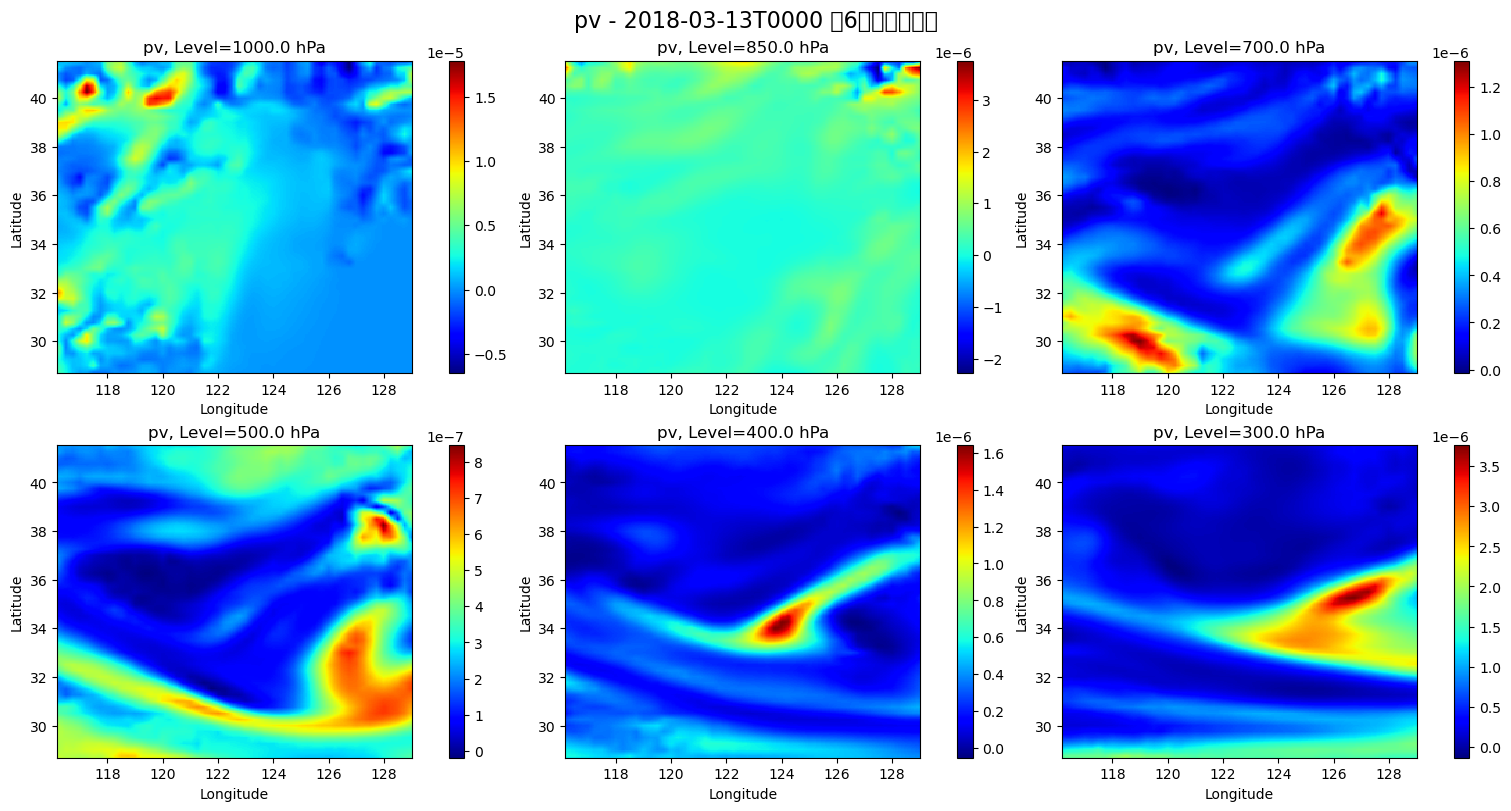

pv 保存完成，共 9 个时间切片
正在处理 r, dims=('valid_time', 'pressure_level', 'lat', 'lon')


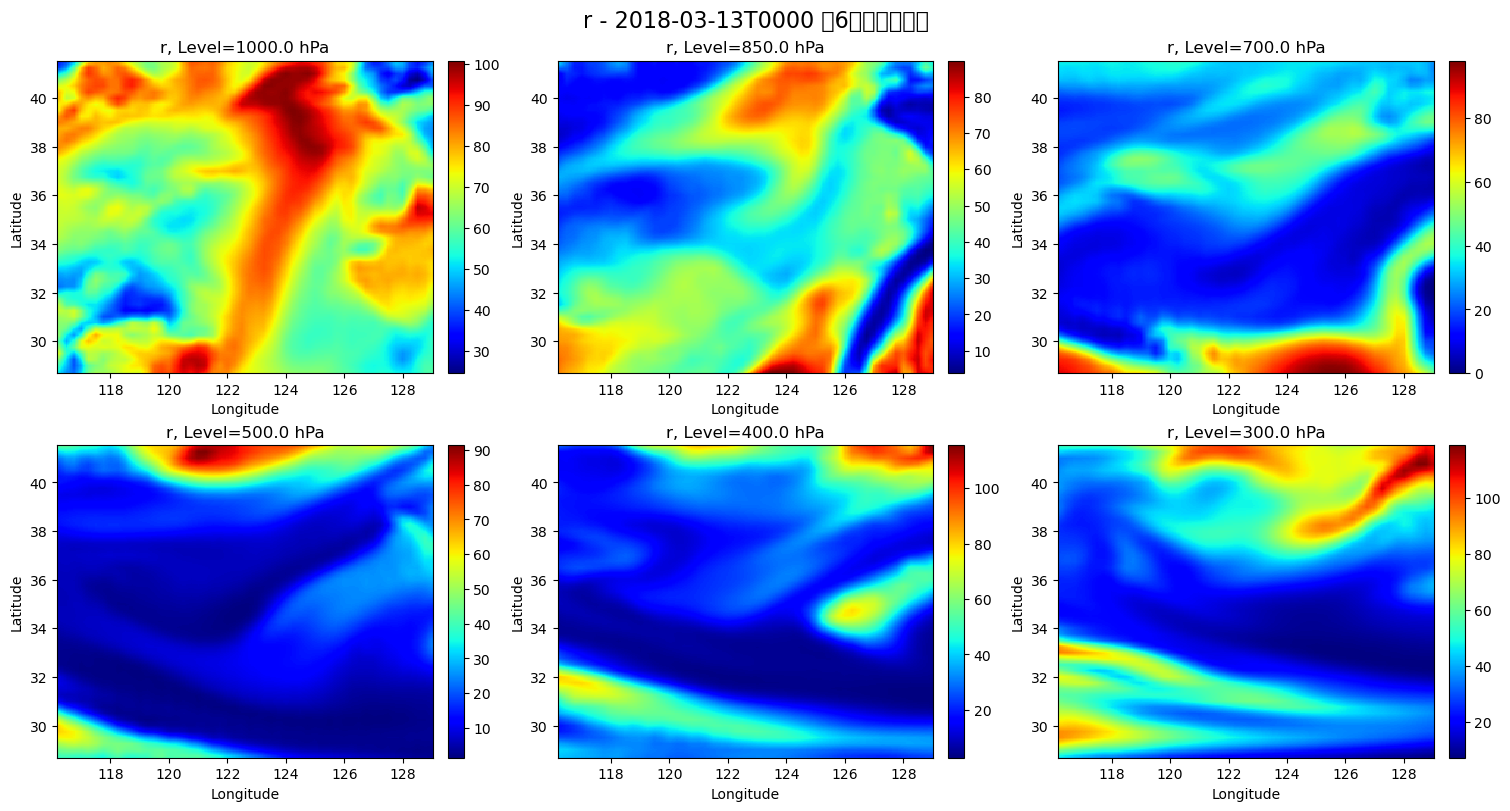

r 保存完成，共 9 个时间切片
正在处理 ciwc, dims=('valid_time', 'pressure_level', 'lat', 'lon')


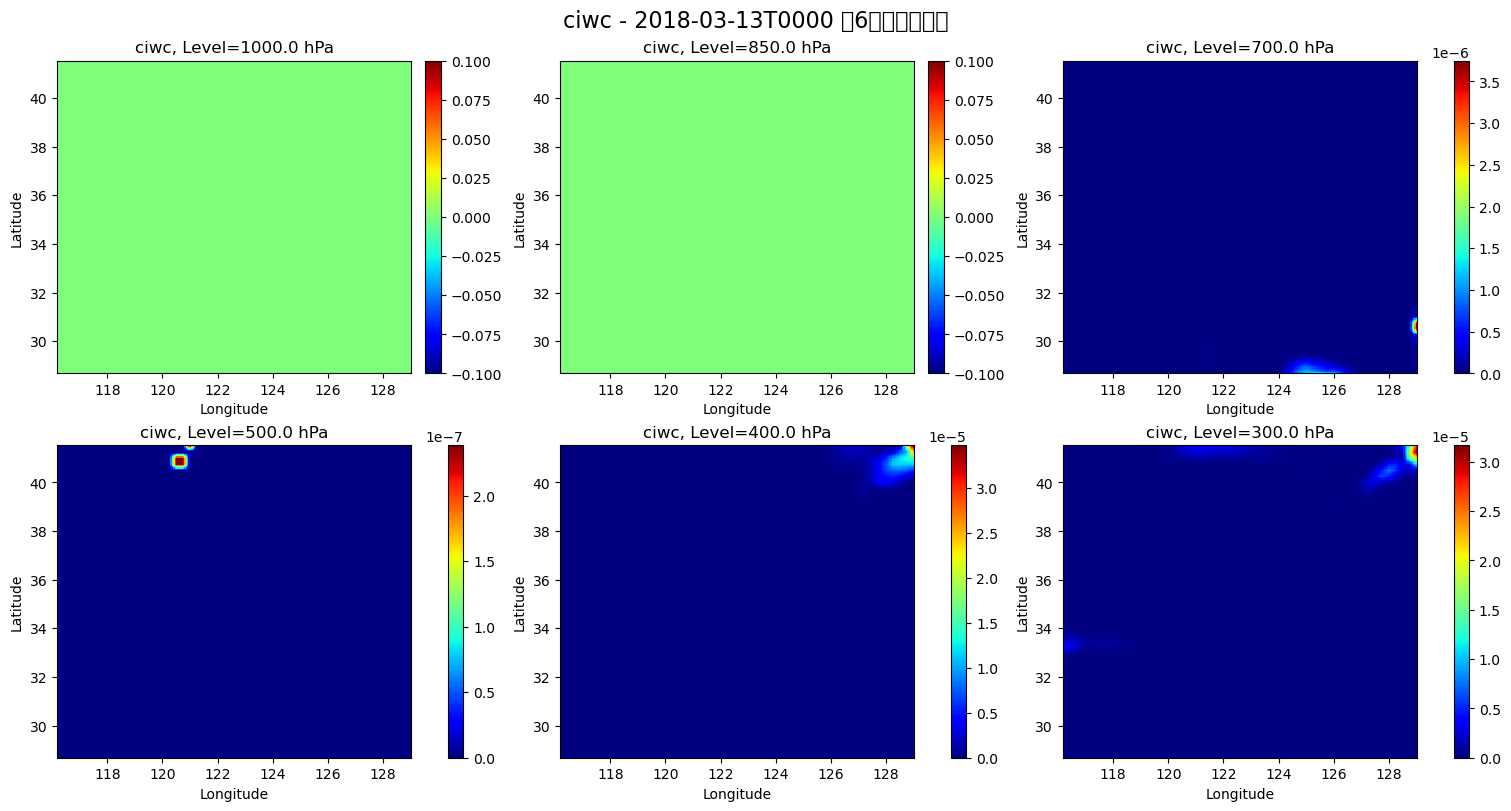

ciwc 保存完成，共 9 个时间切片
正在处理 clwc, dims=('valid_time', 'pressure_level', 'lat', 'lon')


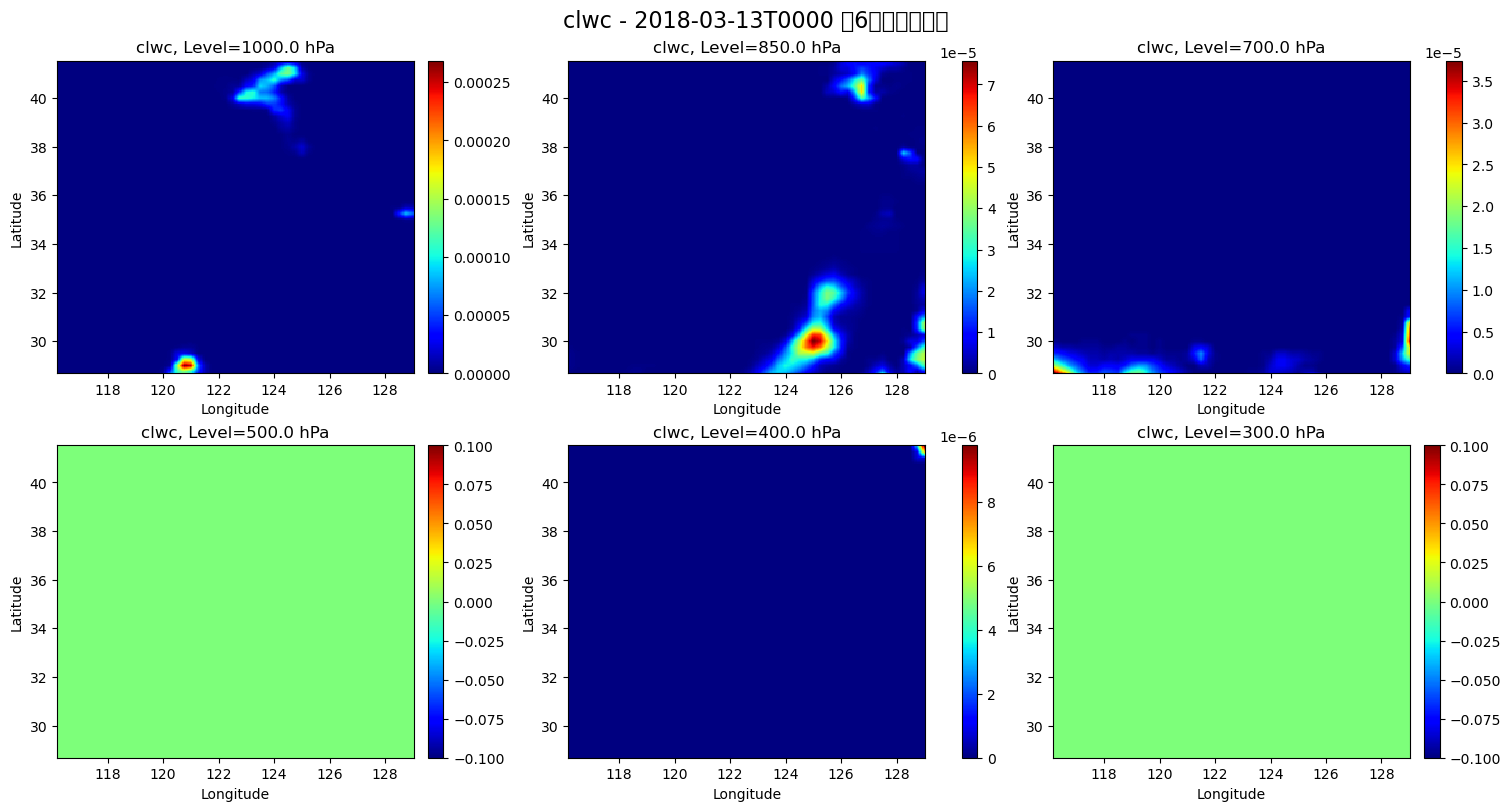

clwc 保存完成，共 9 个时间切片
正在处理 q, dims=('valid_time', 'pressure_level', 'lat', 'lon')


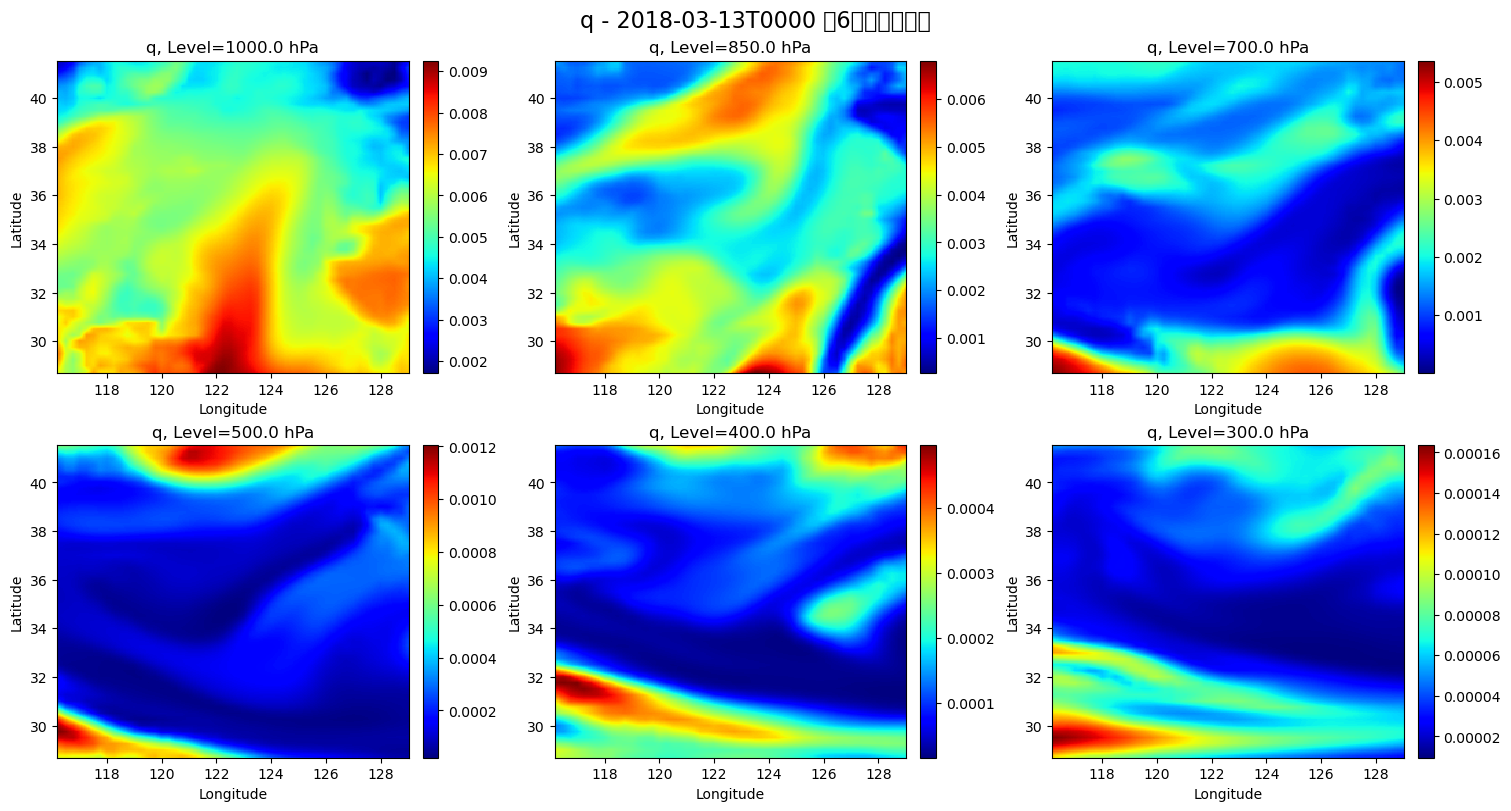

q 保存完成，共 9 个时间切片
正在处理 crwc, dims=('valid_time', 'pressure_level', 'lat', 'lon')


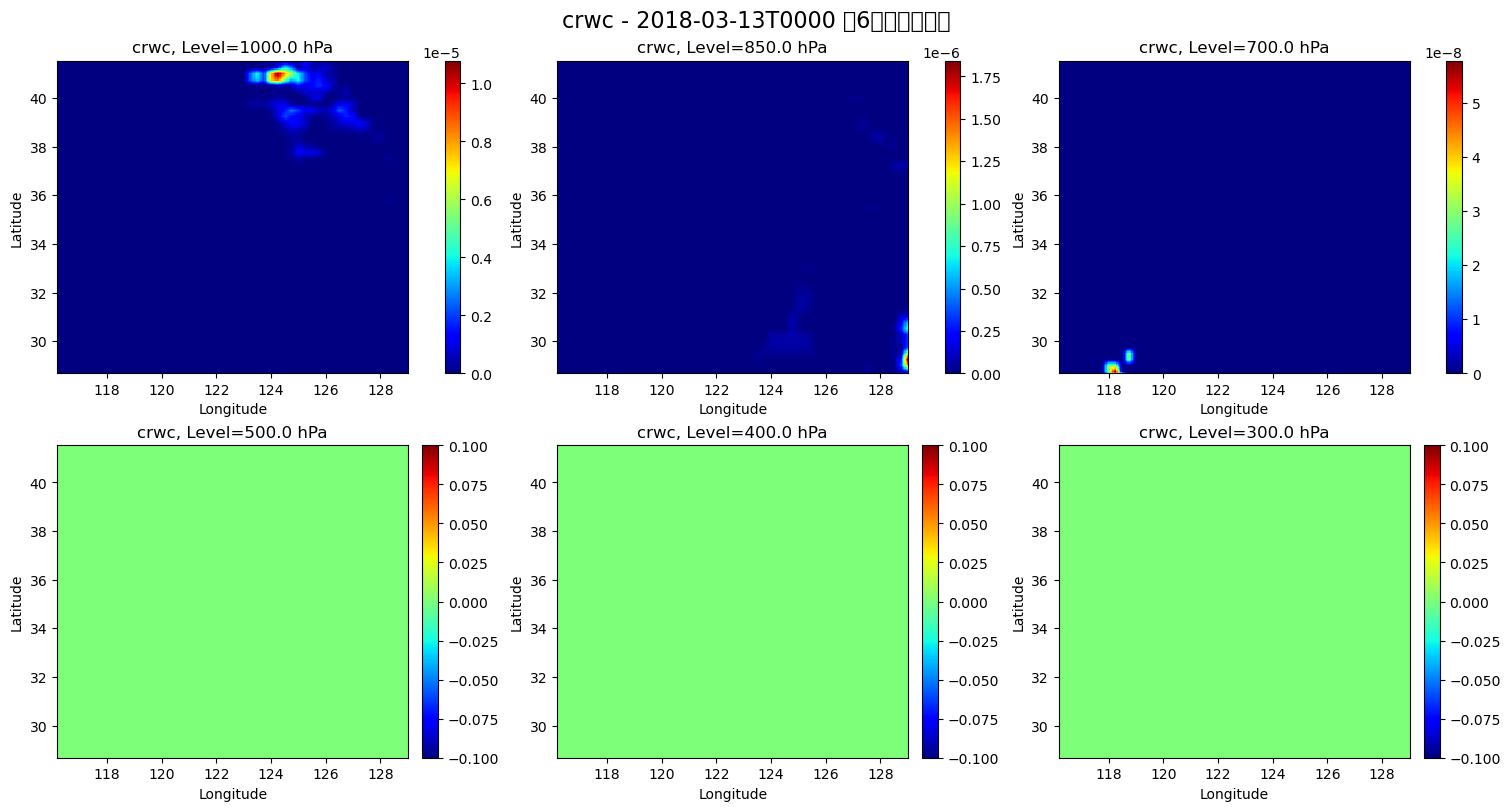

crwc 保存完成，共 9 个时间切片
正在处理 cswc, dims=('valid_time', 'pressure_level', 'lat', 'lon')


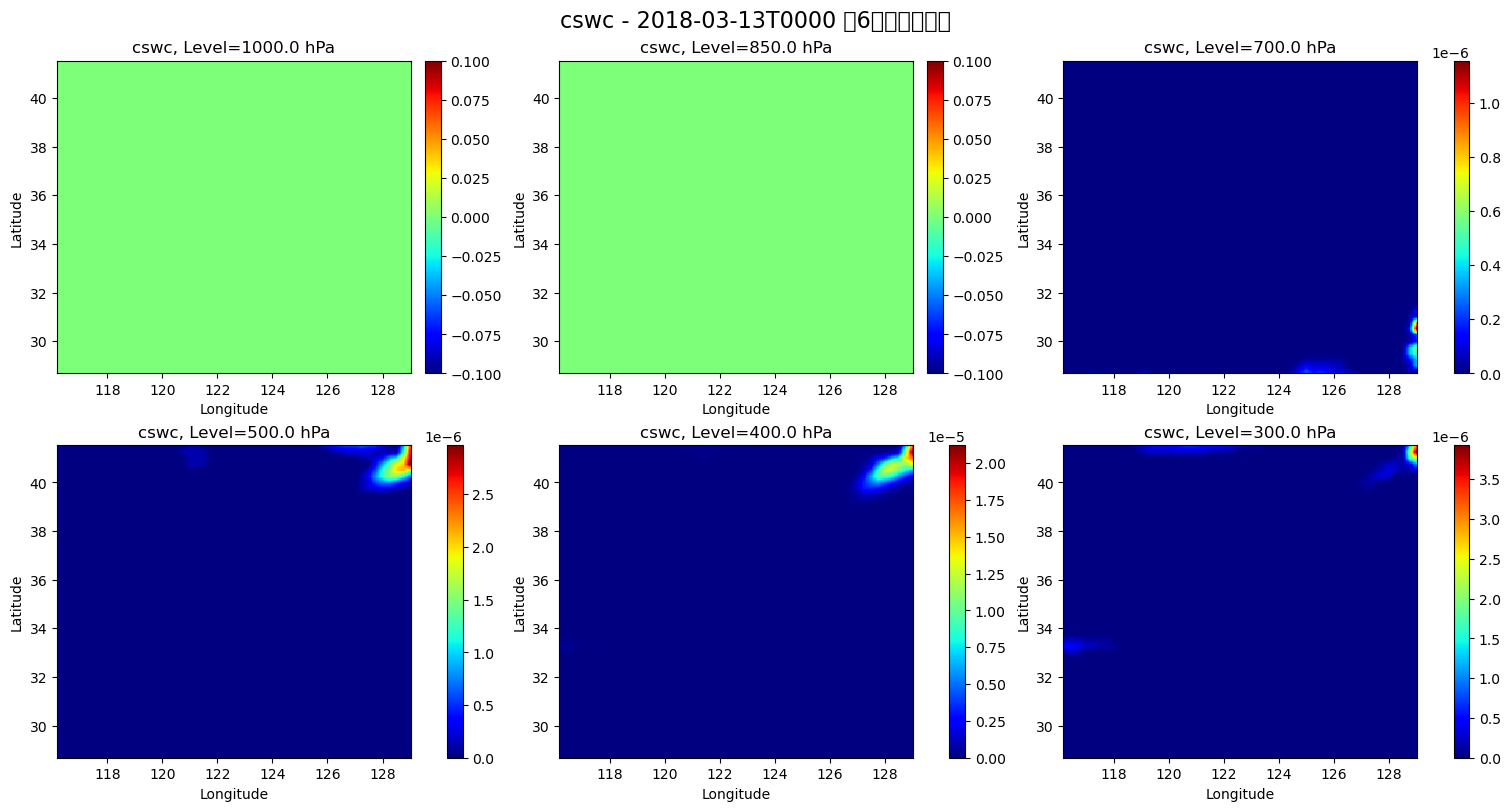

cswc 保存完成，共 9 个时间切片
正在处理 t, dims=('valid_time', 'pressure_level', 'lat', 'lon')


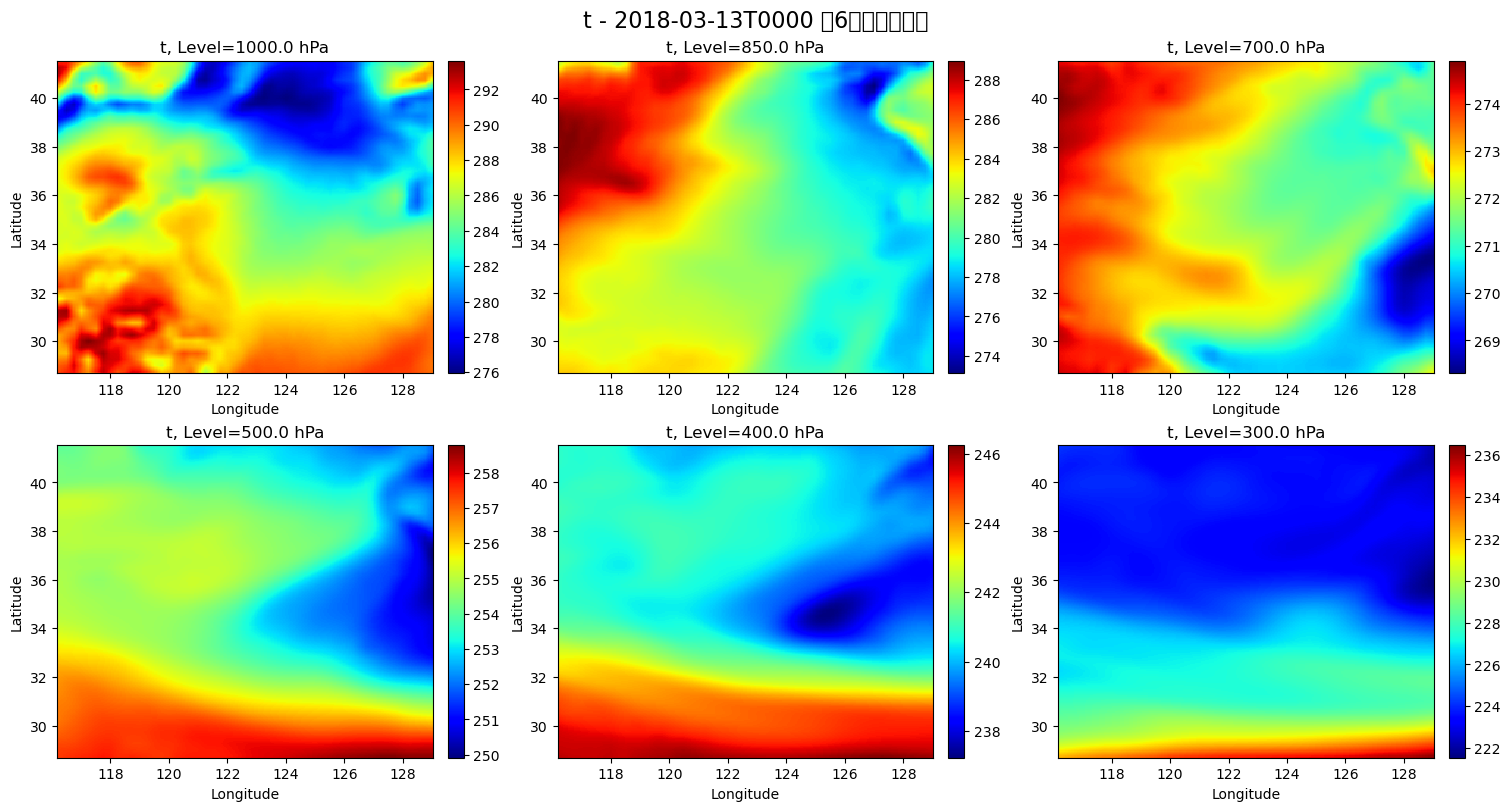

t 保存完成，共 9 个时间切片
正在处理 u, dims=('valid_time', 'pressure_level', 'lat', 'lon')


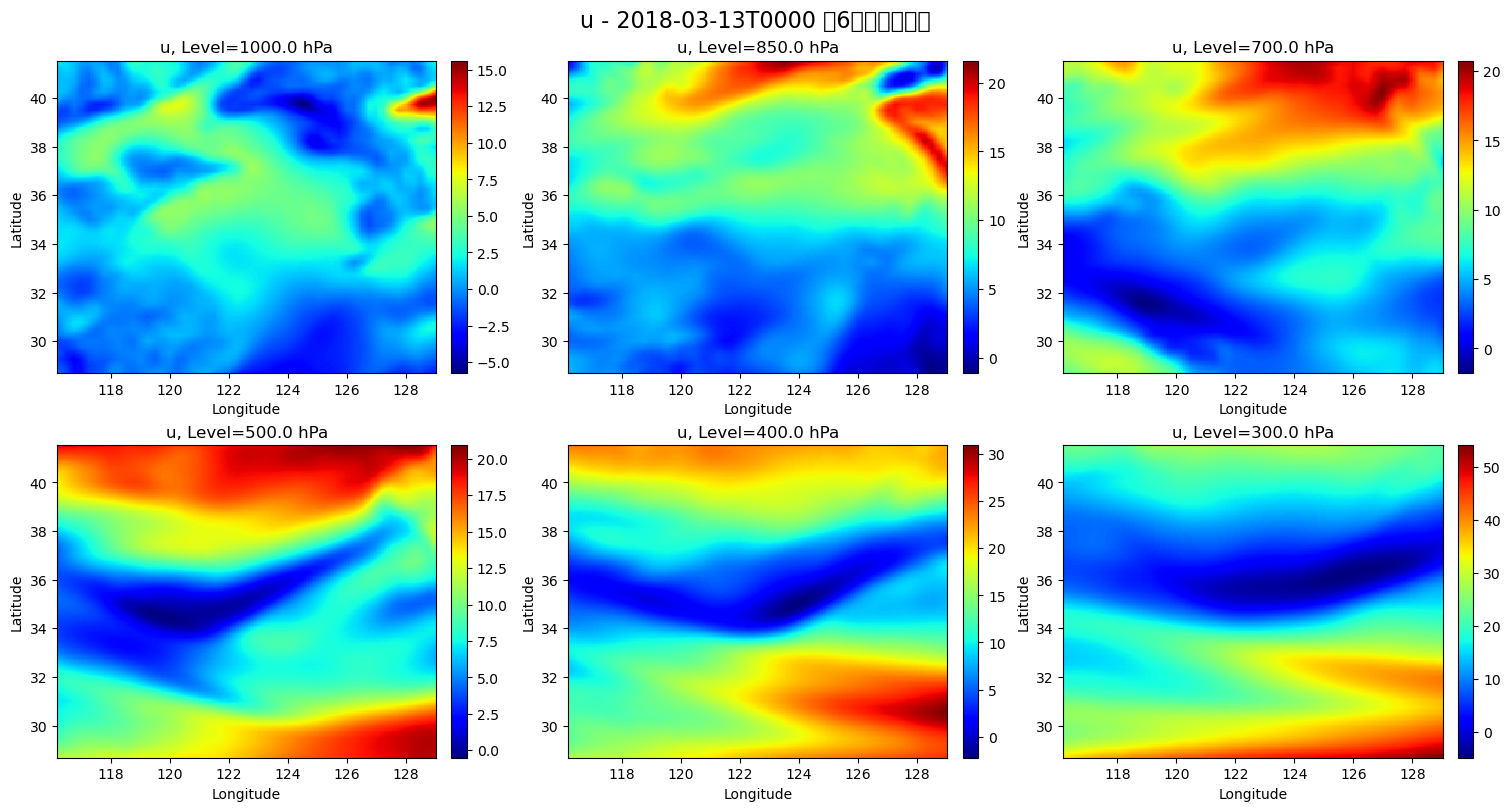

u 保存完成，共 9 个时间切片
正在处理 v, dims=('valid_time', 'pressure_level', 'lat', 'lon')


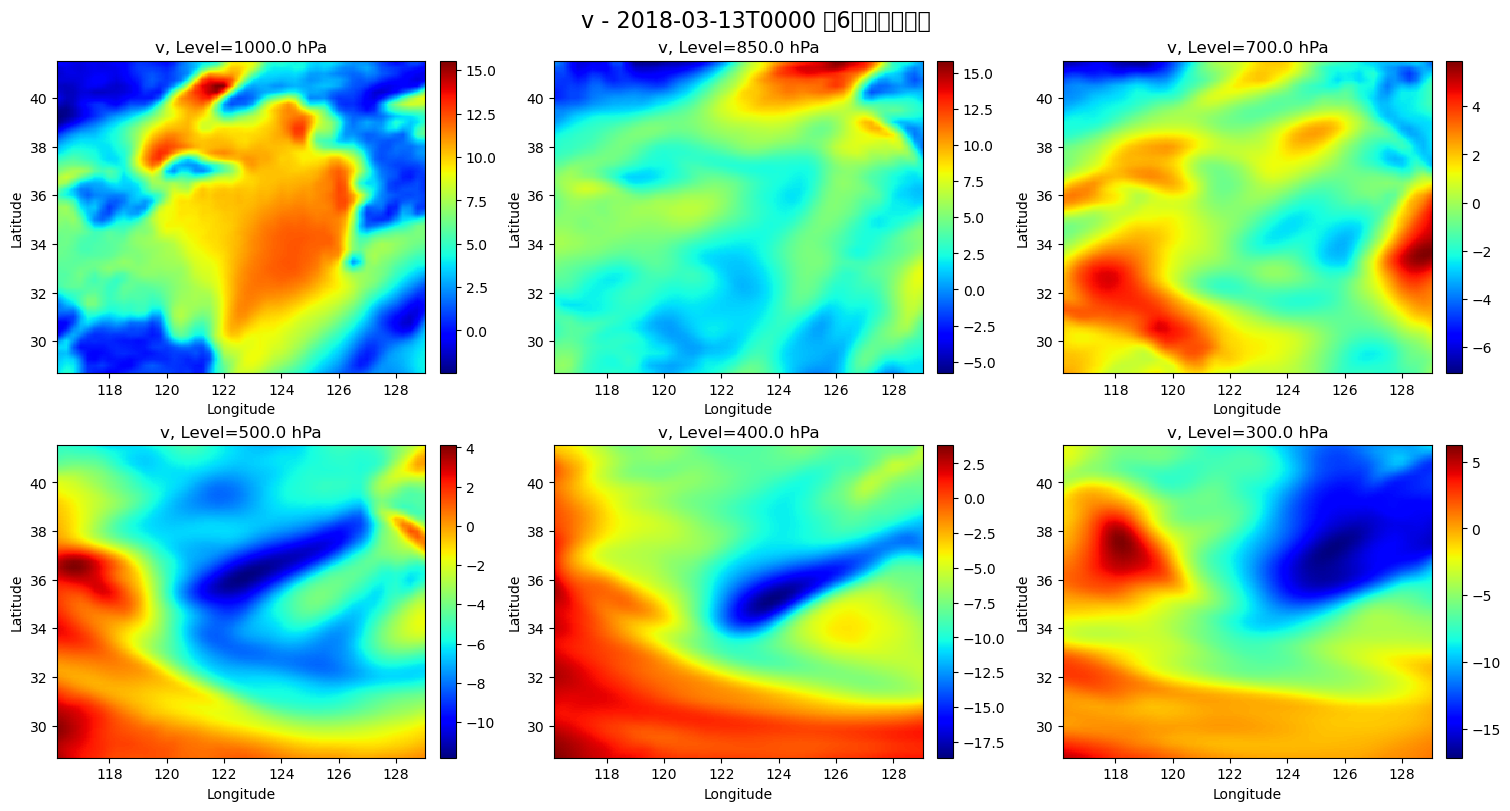

v 保存完成，共 9 个时间切片
正在处理 w, dims=('valid_time', 'pressure_level', 'lat', 'lon')


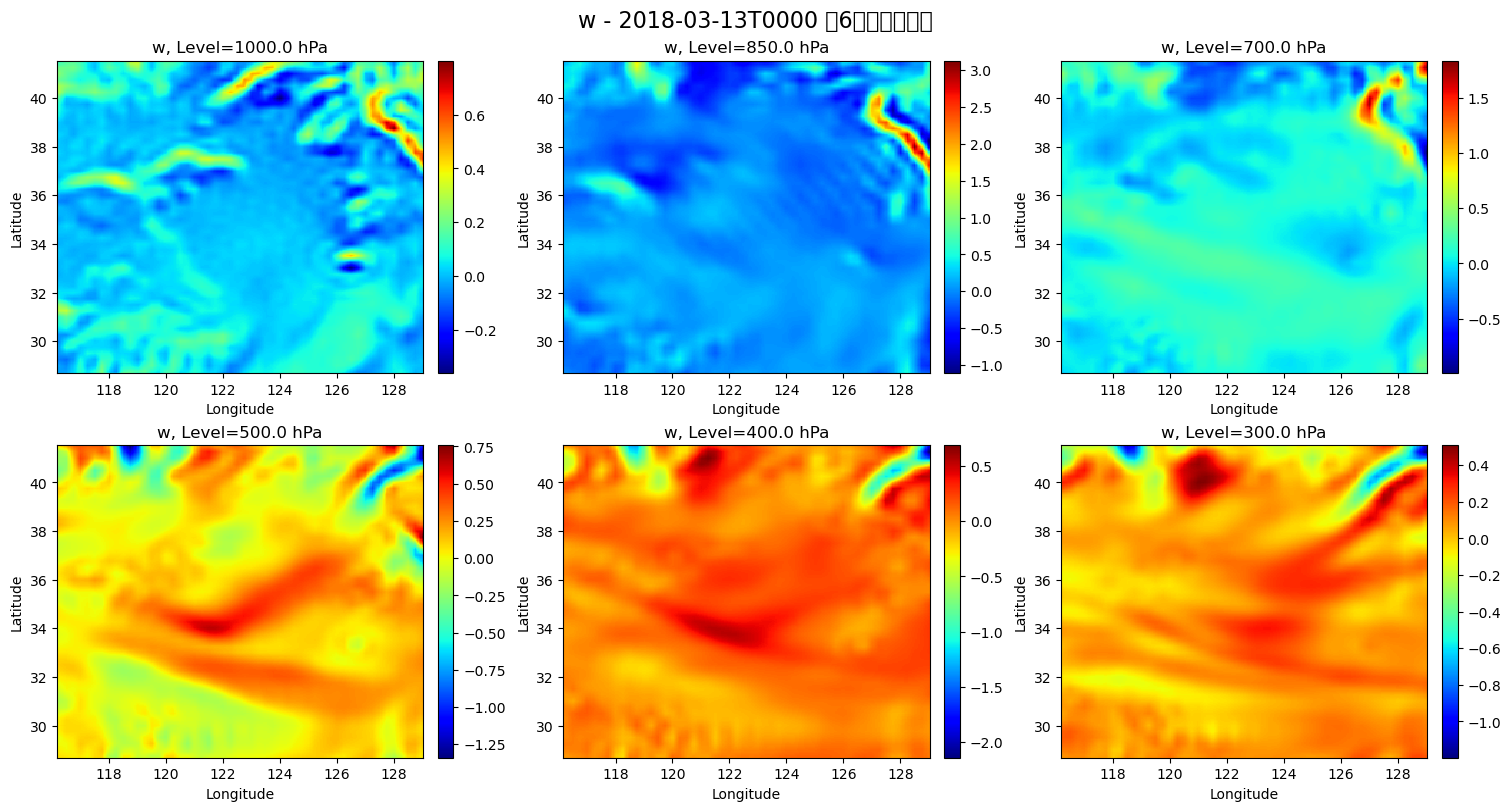

w 保存完成，共 9 个时间切片
正在处理 vo, dims=('valid_time', 'pressure_level', 'lat', 'lon')


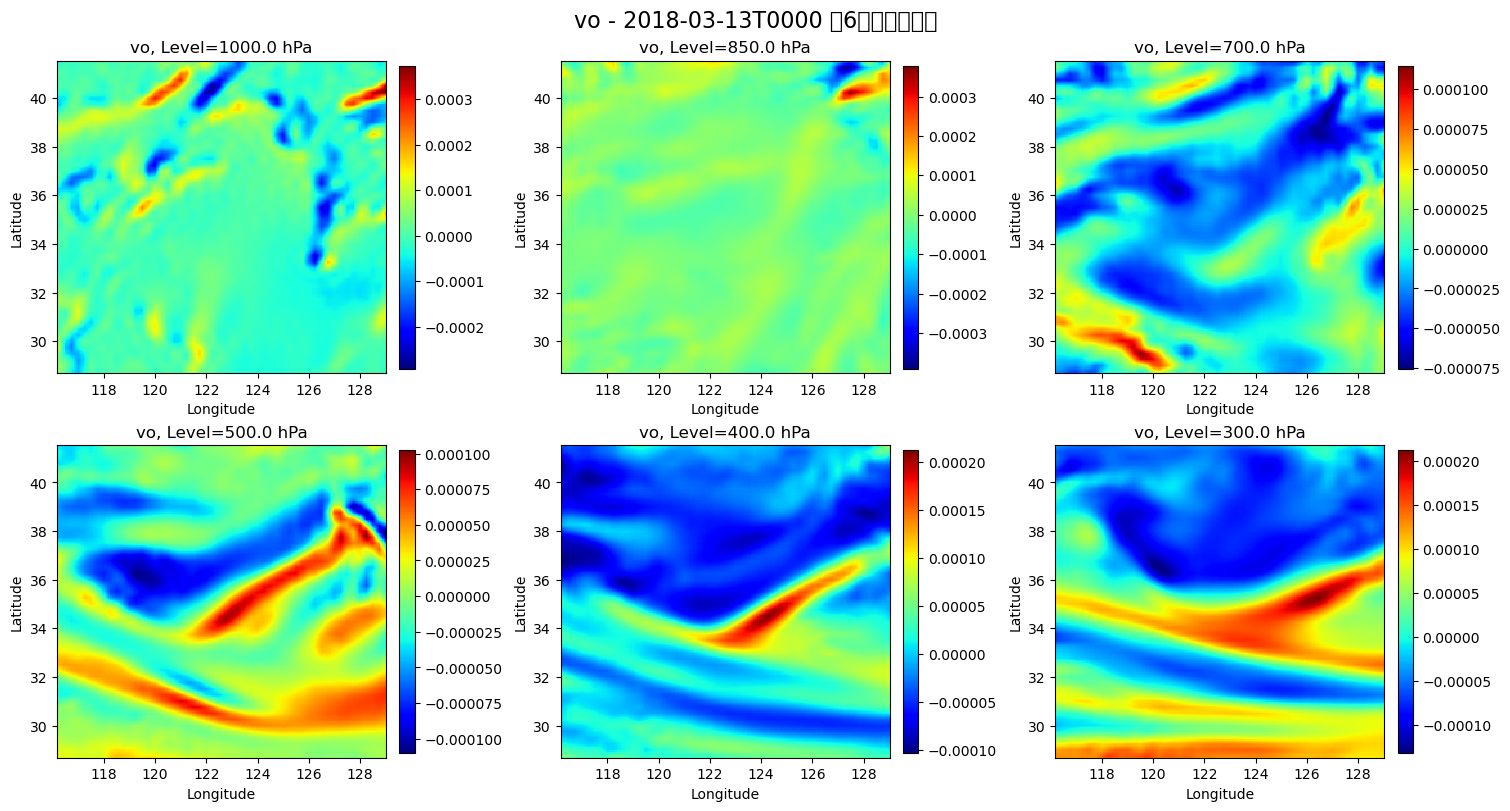

vo 保存完成，共 9 个时间切片


In [13]:
# 插值，可视化，保存
save_root = '/data/xmr/xmrcode/data_process/data/output/era5/pressure_levels'
os.makedirs(save_root, exist_ok=True)

for var_name in var_names:
    if var_name != 'number' and var_name != 'expver':
        var_data = era_ds[var_name]  # (time, level, lat, lon)
        var_folder = os.path.join(save_root, var_name)
        os.makedirs(var_folder, exist_ok=True)
        print(f"正在处理 {var_name}, dims={var_data.dims}")

        for t_idx, t_val in enumerate(var_data.valid_time.values):
            # 时间命名 YYYYMMDD_HHMM
            time_str = np.datetime_as_string(t_val, unit='m').replace(':','')

            # 每个气压层插值
            level_list = []
            for lev in var_data.pressure_level.values:
                lev_data = var_data.isel(valid_time=t_idx).sel(pressure_level=lev)
                lev_interp = regridder(lev_data)  # (y, x)
                level_list.append(lev_interp.values)

            # 合并成 (level, y, x)
            save_array = np.stack(level_list, axis=0)

            # 保存
            save_path = os.path.join(var_folder, f"{time_str}.npy")
            np.save(save_path, save_array)

            # ✅ 可视化：只画第一个时间片，前 6 个气压层
            if t_idx == 0:
                fig, axes = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)
                levels_to_plot = var_data.pressure_level.values[:6]
                for ax, lev, data in zip(axes.flat, levels_to_plot, save_array[:6]):
                    im = ax.pcolormesh(lons_1d, lats_1d, data, cmap='jet')
                    ax.set_title(f"{var_name}, Level={lev} hPa")
                    ax.set_xlabel("Longitude")
                    ax.set_ylabel("Latitude")
                    plt.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)

                plt.suptitle(f"{var_name} - {time_str} 前6层气压层分布", fontsize=16)
                plt.show()

        print(f"{var_name} 保存完成，共 {len(var_data.valid_time)} 个时间切片")